# Setup


In [60]:
# === Imports ===
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func

import scipy.sparse as sp
import networkx as nx
import pickle as pkl
from scipy.sparse.linalg import eigsh
import sys
from torch.optim import Adam
import matplotlib.pyplot as plt


# Utility Functions

In [61]:


def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Return a boolean mask of length l with True at positions in idx."""
    mask = np.zeros(l, dtype=np.bool_)   # np.bool is deprecated
    mask[idx] = True
    return mask


def scipy_coo_to_torch_sparse(coo: sp.coo_matrix, device=None, dtype=torch.float32):
    """Convert a SciPy COO matrix to a torch.sparse_coo_tensor (coalesced)."""
    coo = coo.tocoo()
    indices = np.vstack((coo.row, coo.col))
    i = torch.from_numpy(indices).long()
    v = torch.from_numpy(coo.data).to(dtype)
    shape = coo.shape
    t = torch.sparse_coo_tensor(i, v, torch.Size(shape))
    t = t.coalesce()
    return t.to(device) if device else t



def normalize_adj(adj):
    """Symmetric normalization:  D^{-1/2} A D^{-1/2}  (keeps SciPy COO)."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5, where=rowsum > 0)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return (adj.dot(D_inv_sqrt).transpose().dot(D_inv_sqrt)).tocoo()


def preprocess_adj_to_torch(adj, add_self_loops=True, device=None, dtype=torch.float32):
    """A_hat = normalize(A + I); return torch sparse."""
    if add_self_loops:
        adj = adj + sp.eye(adj.shape[0], dtype=adj.dtype, format='coo')
    adj_norm = normalize_adj(adj)
    return scipy_coo_to_torch_sparse(adj_norm, device=device, dtype=dtype)


def preprocess_features_to_dense(features, device=None, dtype=torch.float32):
    """Row-normalize features (SciPy) and return dense torch.FloatTensor [N, F]."""
    rowsum = np.array(features.sum(1)).flatten()
    r_inv = np.power(rowsum, -1, where=rowsum != 0)
    r_inv[np.isinf(r_inv)] = 0.0
    R_inv = sp.diags(r_inv)
    feats_norm = R_inv.dot(features)          # still SciPy
    # For Cora/Citeseer/Pubmed sizes, dense is fine:
    feats_dense = torch.from_numpy(feats_norm.toarray()).to(dtype)
    return feats_dense.to(device) if device else feats_dense




def load_data_as_torch(dataset_str, device=None, dtype=torch.float32):
    """
    Load citation data (Cora/Citeseer/Pubmed) and return:
      adj_torch_sparse, features_dense, y_train, y_val, y_test, train_mask, val_mask, test_mask
    where labels (y_*) are torch.FloatTensor one-hot (for your masked loss) and masks are torch.BoolTensor.
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for n in names:
        with open(f"data/ind.{dataset_str}.{n}", 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file(f"data/ind.{dataset_str}.test.index")
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix isolated nodes
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder) + 1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range - min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range - min(test_idx_range), :] = ty
        ty = ty_extended

    # Build feature matrix
    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]

    # Build adjacency from graph dict
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))  # SciPy sparse

    # Labels (one-hot)
    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    # Splits (standard GCN)
    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + 500)

    train_mask_np = sample_mask(idx_train, labels.shape[0])
    val_mask_np = sample_mask(idx_val, labels.shape[0])
    test_mask_np = sample_mask(idx_test, labels.shape[0])

    y_train_np = np.zeros_like(labels)
    y_val_np = np.zeros_like(labels)
    y_test_np = np.zeros_like(labels)
    y_train_np[train_mask_np, :] = labels[train_mask_np, :]
    y_val_np[val_mask_np, :] = labels[val_mask_np, :]
    y_test_np[test_mask_np, :] = labels[test_mask_np, :]

    # ---- conversions to torch ----
    adj_torch = preprocess_adj_to_torch(adj, add_self_loops=True, device=device, dtype=dtype)
    features_torch = preprocess_features_to_dense(features, device=device, dtype=dtype)

    y_train = torch.from_numpy(y_train_np).to(dtype).to(device) if device else torch.from_numpy(y_train_np).to(dtype)
    y_val   = torch.from_numpy(y_val_np).to(dtype).to(device)   if device else torch.from_numpy(y_val_np).to(dtype)
    y_test  = torch.from_numpy(y_test_np).to(dtype).to(device)  if device else torch.from_numpy(y_test_np).to(dtype)

    train_mask = torch.from_numpy(train_mask_np).to(torch.bool).to(device) if device else torch.from_numpy(train_mask_np).to(torch.bool)
    val_mask   = torch.from_numpy(val_mask_np).to(torch.bool).to(device)   if device else torch.from_numpy(val_mask_np).to(torch.bool)
    test_mask  = torch.from_numpy(test_mask_np).to(torch.bool).to(device)  if device else torch.from_numpy(test_mask_np).to(torch.bool)

    return adj_torch, features_torch, y_train, y_val, y_test, train_mask, val_mask, test_mask


def create_plots(metrics):
    _train_losses = metrics['train_losses']
    _val_losses = metrics['val_losses']
    _train_acc = metrics['train_acc']
    _val_acc = metrics['val_acc']



    epochs = range(1, len(_train_losses) + 1)

    print("\n--- Model Performance ---")
    print(f"| Epoch | Train. Loss | Val. Loss   | Train. Acc. | Val. Acc. |")
    print(f"|-------|-------------|-------------|-------------|-----------|")
    for epoch, (train_loss, val_loss, train_acc, val_acc) in enumerate(zip(_train_losses, _val_losses, _train_acc, _val_acc), start=1):
        print(f"| {epoch}     | {train_loss:.4f}      | {val_loss:.4f}      | {train_acc:.4f}      | {val_acc:.4f}     |")
    plt.figure(figsize=(10, 10))

    plt.plot(epochs, _train_losses, label='Training Loss')
    plt.plot(epochs, _val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.show()


    plt.figure(figsize=(10, 10))
    plt.plot(epochs, _train_acc, label='Training Accuracy')
    plt.plot(epochs, _val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.show()

# Metrics

In [62]:
def masked_softmax_cross_entropy(preds, labels, mask):
    
    labels = labels.argmax(dim=1)
    loss = func.cross_entropy(preds, labels, reduction='none')

    mask = mask.float()
    mask /= mask.mean()
    loss *= mask

    return loss.mean()


def masked_accuracy(preds, labels, mask):
 

    pred_classes = torch.argmax(preds, dim=1)
    true_classes = torch.argmax(labels, dim=1)

    correct_prediction = (pred_classes == true_classes).float()

    # Convert mask to float and normalize it
    mask = mask.float()
    mask = mask / mask.mean()
    correct_prediction *= mask

    return correct_prediction.mean()

# Layers


In [63]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias = True):
        super(GraphConvolution,self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features,out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)
    
    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj,support) if adj.is_sparse else torch.mm(adj,support)
        if self.bias is not None:
            output += self.bias
        
        return output

class GCN(nn.Module):
    def __init__(self, in_features, hidden_dim, class_num, dropout, bias=True):
        super().__init__()
        self.gcn_1 = GraphConvolution(in_features, hidden_dim, bias)
        self.gcn_2 = GraphConvolution(hidden_dim, class_num, bias)  
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x, adj):
        x = func.relu(self.gcn_1(x, adj))
        x = self.dropout(x)
        x = self.gcn_2(x, adj)   # logits
        return x
    
    

# Training


In [64]:
def train_gcn(dataset='cora',
              hidden_dim=16,
              dropout=0.5,
              lr=0.01,
              weight_decay=5e-4,
              epochs=200,
              patience=10,
              seed=42):

    torch.manual_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Storing values for plots
    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    # Load data (adj sparse torch, features dense torch, labels one-hot, masks bool)
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = \
        load_data_as_torch(dataset, device=device, dtype=torch.float32)
    
  

    num_nodes, in_features = features.shape
    num_classes = y_train.shape[1]

    model = GCN(in_features, hidden_dim, num_classes, dropout=dropout).to(device)

    
    optimizer = Adam([
    {'params': model.gcn_1.parameters(), 'weight_decay': 5e-4},  # regularized
    {'params': model.gcn_2.parameters(), 'weight_decay': 0.0}    # no regularization
    ], lr=lr)

    


    best_val = -float('inf')
    best_state = None
    wait = 0

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        logits = model(features, adj)  # [N, C]
        loss_train = masked_softmax_cross_entropy(logits, y_train, train_mask)
        acc_train = masked_accuracy(logits, y_train, train_mask)

        loss_train.backward()
        optimizer.step()

        # ---- validation ----
        model.eval()
        with torch.no_grad():
            logits = model(features, adj)
            loss_val = masked_softmax_cross_entropy(logits, y_val, val_mask)
            acc_val = masked_accuracy(logits, y_val, val_mask)

        # print(f"Epoch {epoch:03d} | "
            #   f"Train Loss {loss_train.item():.4f} Acc {acc_train.item():.4f} | "
            #   f"Val Loss {loss_val.item():.4f} Acc {acc_val.item():.4f}")

        # Early stopping on validation accuracy (or use -loss)
        score = acc_val.item()
        if score > best_val:
            best_val = score
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}. Best val acc: {best_val:.4f}")
                break

        # Appending data to lists
        train_losses.append(loss_train.item())
        val_losses.append(loss_val.item())
        train_acc.append(acc_train.item())
        val_acc.append(acc_val.item())

    
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits = model(features, adj)
        test_loss = masked_softmax_cross_entropy(logits, y_test, test_mask).item()
        test_acc = masked_accuracy(logits, y_test, test_mask).item()
    # print(f"Test  | Loss {test_loss:.4f} Acc {test_acc:.4f}")

    return model, {'val_acc': best_val, 'test_acc': test_acc, 
                   'train_losses': train_losses, 
                   'val_losses': val_losses, 
                   'train_acc': train_acc,
                   'val_acc': val_acc
                   }


C:\Users\sushi\AppData\Local\Temp\ipykernel_45460\3607219814.py:71: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  objects.append(pkl.load(f, encoding='latin1'))
C:\Users\sushi\AppData\Local\Temp\ipykernel_45460\2003895035.py:12: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.weight)


Early stopping at epoch 78. Best val acc: 0.7000

--- Model Performance ---
| Epoch | Train. Loss | Val. Loss   | Train. Acc. | Val. Acc. |
|-------|-------------|-------------|-------------|-----------|
| 1     | 1.7916      | 1.7904      | 0.1583      | 0.2100     |
| 2     | 1.7860      | 1.7874      | 0.2667      | 0.2120     |
| 3     | 1.7818      | 1.7839      | 0.3583      | 0.3240     |
| 4     | 1.7734      | 1.7810      | 0.4250      | 0.4600     |
| 5     | 1.7694      | 1.7782      | 0.4583      | 0.4860     |
| 6     | 1.7587      | 1.7757      | 0.5667      | 0.4920     |
| 7     | 1.7501      | 1.7731      | 0.6917      | 0.4980     |
| 8     | 1.7385      | 1.7701      | 0.7250      | 0.5420     |
| 9     | 1.7330      | 1.7665      | 0.6833      | 0.5420     |
| 10     | 1.7240      | 1.7629      | 0.7500      | 0.5480     |
| 11     | 1.7193      | 1.7595      | 0.6750      | 0.5480     |
| 12     | 1.7032      | 1.7566      | 0.6667      | 0.5440     |
| 13     | 1.

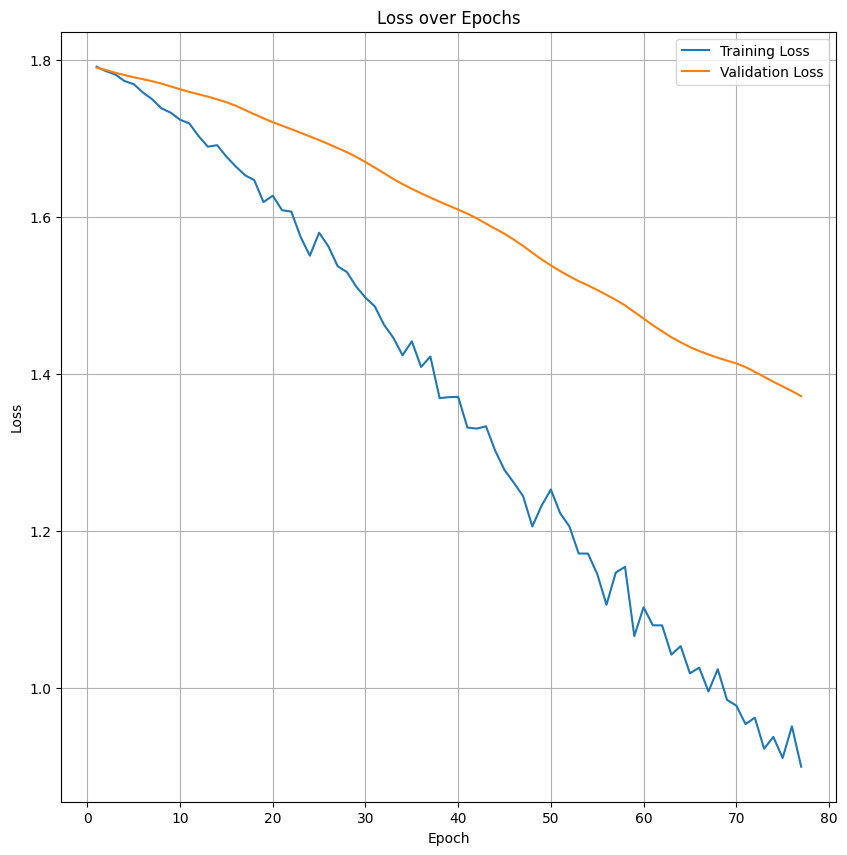

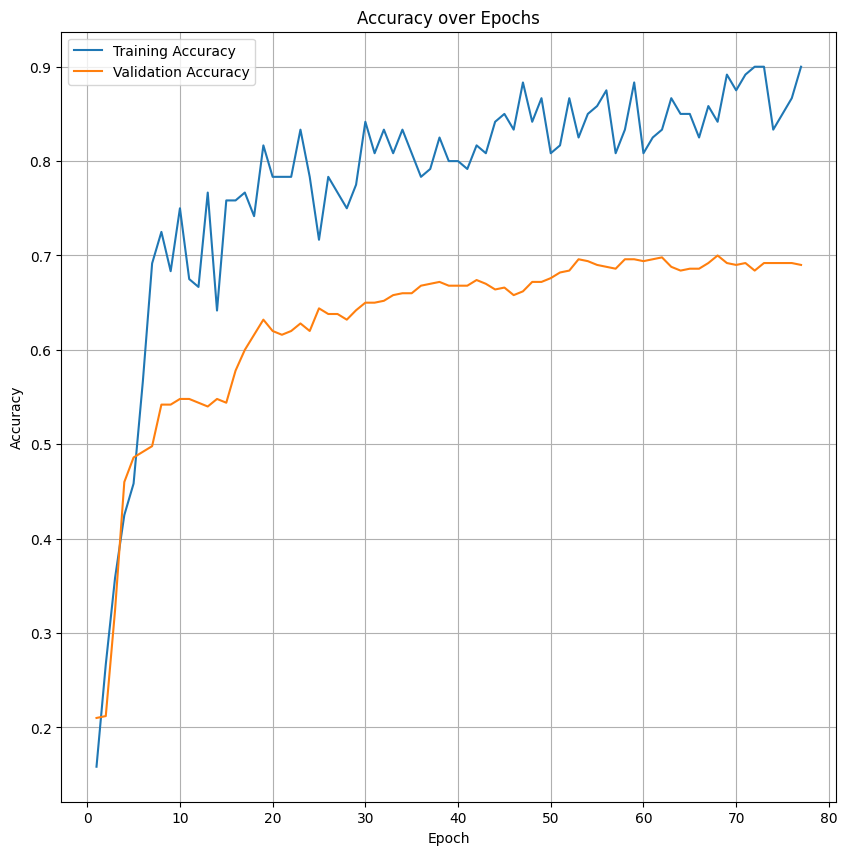

In [65]:
model, metrics = train_gcn(dataset='citeseer')
create_plots(metrics)



C:\Users\sushi\AppData\Local\Temp\ipykernel_45460\3607219814.py:71: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  objects.append(pkl.load(f, encoding='latin1'))
C:\Users\sushi\AppData\Local\Temp\ipykernel_45460\2003895035.py:12: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.weight)


Early stopping at epoch 50. Best val acc: 0.7660

--- Model Performance ---
| Epoch | Train. Loss | Val. Loss   | Train. Acc. | Val. Acc. |
|-------|-------------|-------------|-------------|-----------|
| 1     | 1.9459      | 1.9449      | 0.1786      | 0.1960     |
| 2     | 1.9409      | 1.9423      | 0.2643      | 0.2640     |
| 3     | 1.9341      | 1.9374      | 0.4071      | 0.4340     |
| 4     | 1.9259      | 1.9326      | 0.6071      | 0.4580     |
| 5     | 1.9149      | 1.9294      | 0.5357      | 0.3640     |
| 6     | 1.9093      | 1.9265      | 0.5500      | 0.3460     |
| 7     | 1.9004      | 1.9220      | 0.4714      | 0.3480     |
| 8     | 1.8863      | 1.9164      | 0.4786      | 0.3540     |
| 9     | 1.8754      | 1.9100      | 0.5500      | 0.4040     |
| 10     | 1.8651      | 1.9026      | 0.5643      | 0.4560     |
| 11     | 1.8587      | 1.8939      | 0.6071      | 0.5300     |
| 12     | 1.8428      | 1.8834      | 0.6214      | 0.5880     |
| 13     | 1.

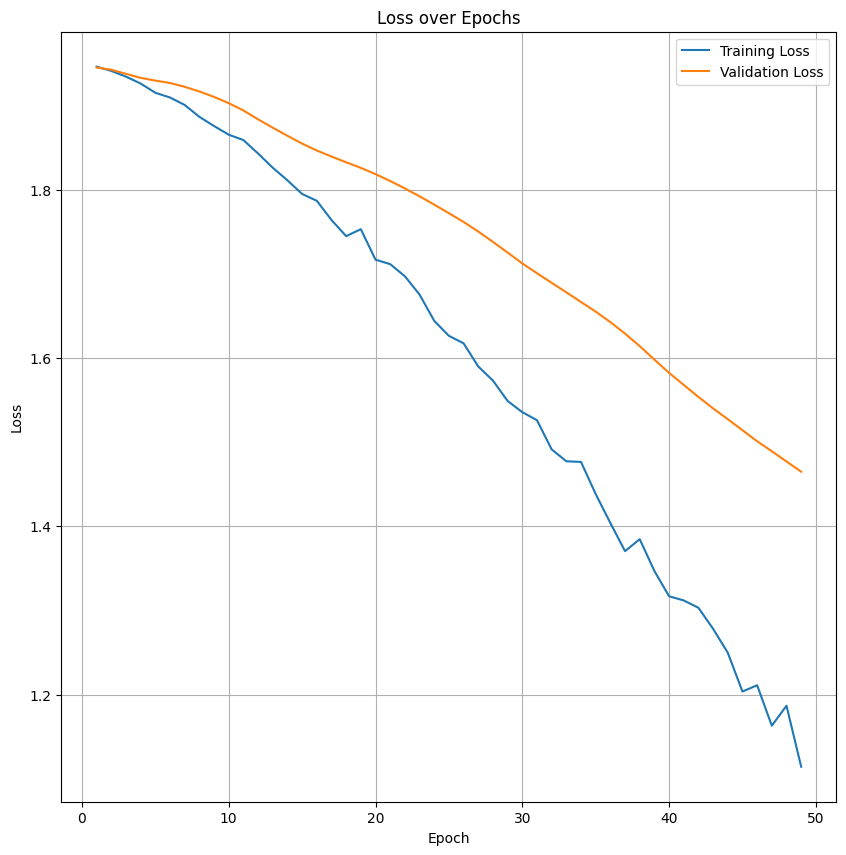

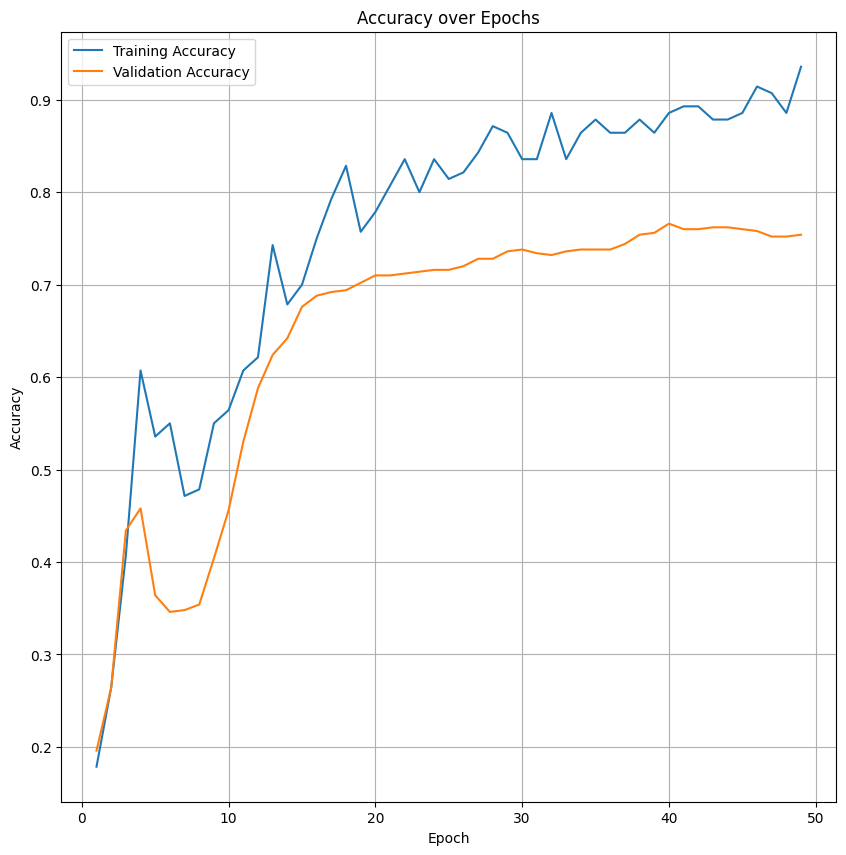

In [66]:
# Cora
model, m = train_gcn(dataset='cora')
create_plots(m)

C:\Users\sushi\AppData\Local\Temp\ipykernel_45460\3607219814.py:71: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  objects.append(pkl.load(f, encoding='latin1'))
C:\Users\sushi\AppData\Local\Temp\ipykernel_45460\2003895035.py:12: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.weight)


Early stopping at epoch 80. Best val acc: 0.7980

--- Model Performance ---
| Epoch | Train. Loss | Val. Loss   | Train. Acc. | Val. Acc. |
|-------|-------------|-------------|-------------|-----------|
| 1     | 1.0966      | 1.0963      | 0.5167      | 0.4640     |
| 2     | 1.0896      | 1.0931      | 0.5167      | 0.5600     |
| 3     | 1.0860      | 1.0874      | 0.6000      | 0.6860     |
| 4     | 1.0757      | 1.0798      | 0.7000      | 0.6340     |
| 5     | 1.0676      | 1.0727      | 0.7000      | 0.5640     |
| 6     | 1.0550      | 1.0674      | 0.7167      | 0.5740     |
| 7     | 1.0441      | 1.0629      | 0.8000      | 0.6300     |
| 8     | 1.0307      | 1.0584      | 0.7500      | 0.6580     |
| 9     | 1.0344      | 1.0537      | 0.7833      | 0.6820     |
| 10     | 1.0180      | 1.0487      | 0.7833      | 0.6980     |
| 11     | 1.0080      | 1.0427      | 0.8000      | 0.7040     |
| 12     | 0.9925      | 1.0354      | 0.8167      | 0.7020     |
| 13     | 0.

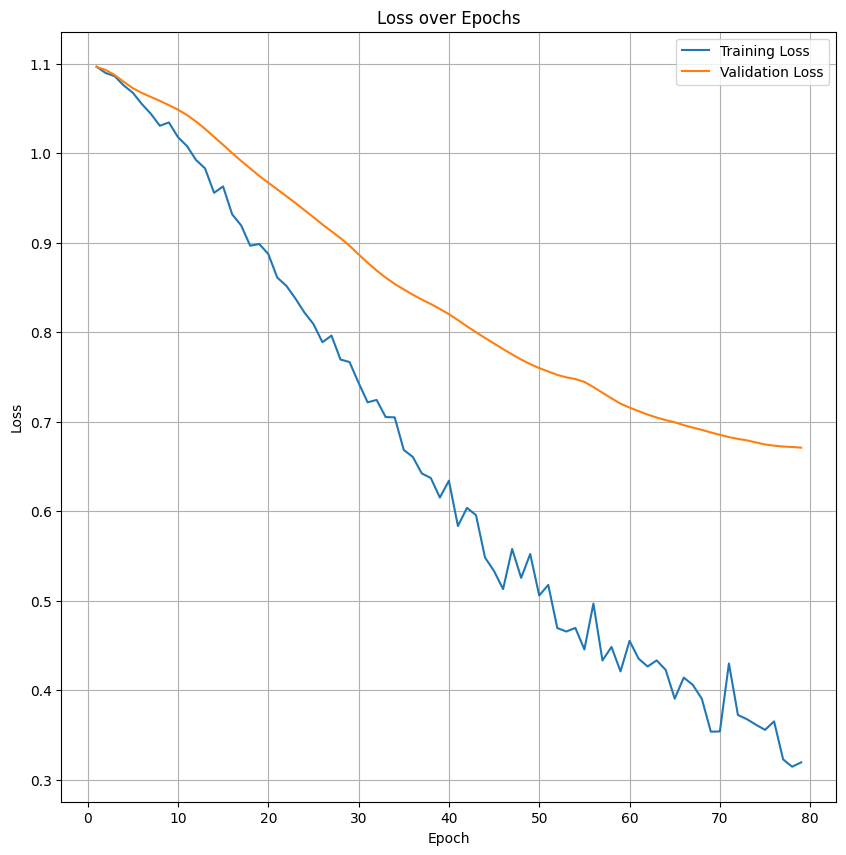

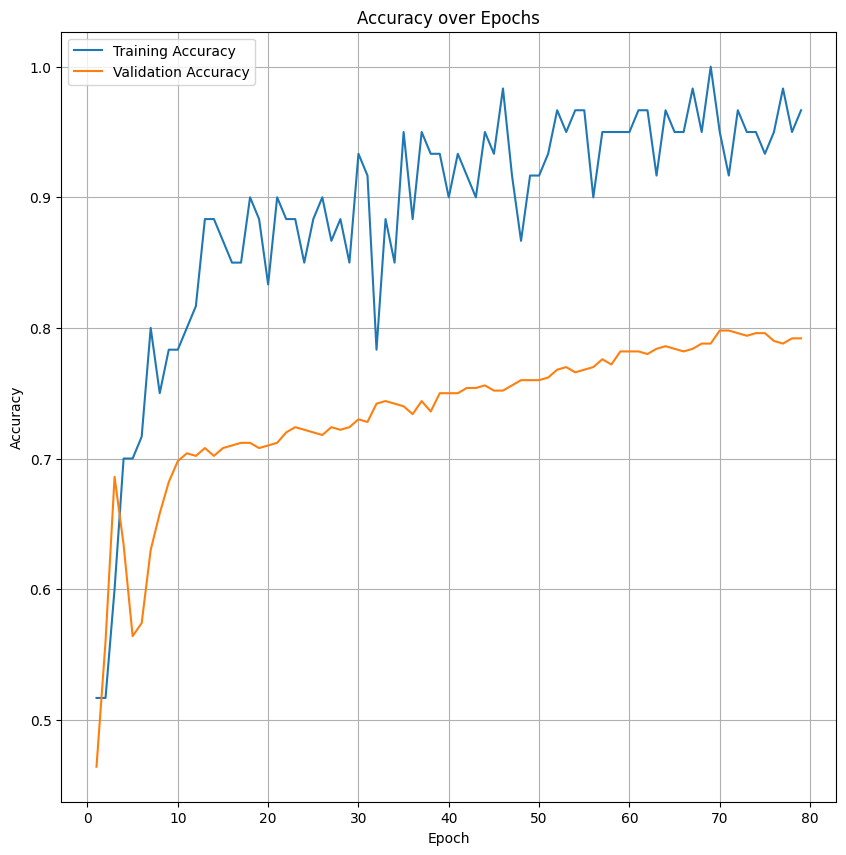

In [67]:
#Pubmed
model, m = train_gcn(dataset='pubmed')
create_plots(m)
